In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

In [2]:
print(len(tf.config.list_physical_devices('GPU')))

1


# First, we do not use data augmentation

In [3]:
train_dir = "/home/linux/Tensorflow Notebooks/Animal Classification Dataset/Training Data/Training Data"
validation_dir = "/home/linux/Tensorflow Notebooks/Animal Classification Dataset/Validation Data/Validation Data"
test_dir = "/home/linux/Tensorflow Notebooks/Animal Classification Dataset/Testing Data/Testing Data"

# Shuffling the training dataset is crucial
# No need to shuffle the validation set and the test set because they are only used for evaluation
train_data = tf.keras.utils.image_dataset_from_directory(directory = train_dir, batch_size = 32, label_mode = "categorical", image_size = (224,224),shuffle = True)
validation_data = tf.keras.utils.image_dataset_from_directory(directory = validation_dir, batch_size = 32, label_mode = "categorical", image_size = (224,224), shuffle = False)
test_data = tf.keras.utils.image_dataset_from_directory(directory = test_dir, batch_size = 32, image_size = (224,224), label_mode = "categorical", shuffle = False)

validation_data = tf.data.Dataset.concatenate(validation_data, test_data)

Found 30000 files belonging to 15 classes.
Found 2000 files belonging to 15 classes.
Found 2404 files belonging to 15 classes.


In [4]:
#finding out the number of classes
class_names = train_data.class_names
print(class_names)
print(len(class_names))

['Beetle', 'Butterfly', 'Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Lizard', 'Monkey', 'Mouse', 'Panda', 'Spider', 'Tiger', 'Zebra']
15


In [5]:
#finding out the number of batches in the train, validation and test datasets
print("Batches in train data {}".format(len(train_data)))
print("Batches in validation data {}".format(len(validation_data)))
print("batches in test data {}".format(len(test_data)))

Batches in train data 938
Batches in validation data 139
batches in test data 76


tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(15,), dtype=float32)


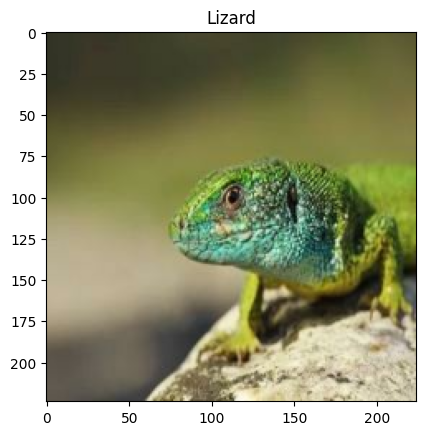

In [13]:
train_sample = train_data.take(1)
for image, label in train_sample:
  pass
print(label[0])
plt.imshow(image[0]/255.0)
plt.title(class_names[tf.argmax(label[0])])
plt.show()
# as expected, .take(1) return 1 element from the dataset and since our dataset contains batches, 1 element would mean a batch of 32
# and the labels are also one hot encoded with a dimension of 15 (corresponding to the number of classes)

In [51]:
# defining a plotting function to plot the images from the dataset
def plot_images(train_data):
  train_sample = train_data.take(1)
  for image, label in train_sample:
    pass
  plt.figure(figsize = (15,10))
  for index in range(3):
    plt.subplot(1,3,index+1)
    img = image[index]
    title = label[index]
    plt.imshow(img/255.0)
    plt.axis = "off"
    plt.title(class_names[tf.argmax(title)])

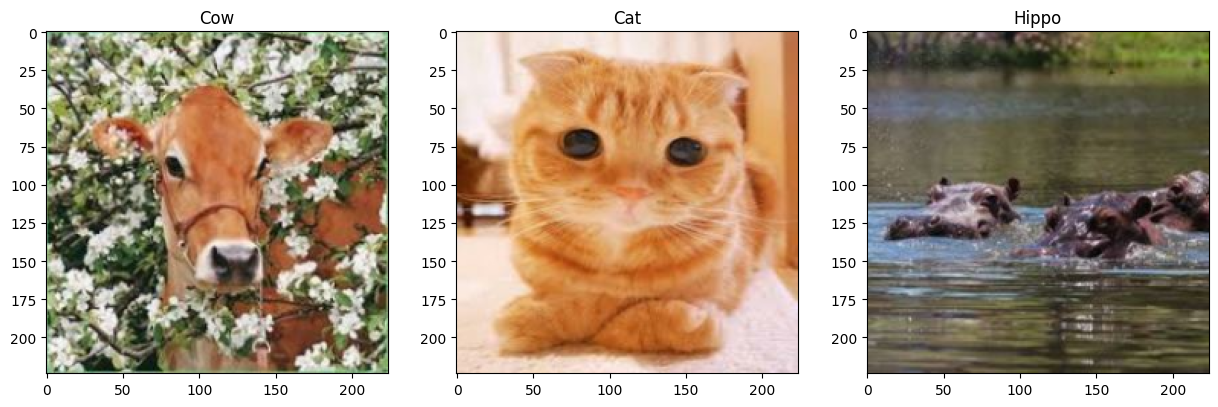

In [52]:
plot_images(train_data)

# Time to create a Base line model (based on Tiny VGG)

In [6]:
#here we do not use data augmentation
base_model = tf.keras.Sequential()
base_model.add(tf.keras.layers.Input(shape = (224,224,3)))
base_model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
base_model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
base_model.add(tf.keras.layers.MaxPool2D())
base_model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
base_model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
base_model.add(tf.keras.layers.MaxPool2D())
base_model.add(tf.keras.layers.Flatten())
base_model.add(tf.keras.layers.Dense(50, activation = "relu"))
base_model.add(tf.keras.layers.Dense(15, activation = "softmax"))

#creating a checkpoint callback
checkpoint_dir = "/home/linux/Tensorflow Notebooks/Tensorflow Checkpoints/Base_mode_no_data_augment"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_dir, save_weights_only = True, save_best_only = True)

#compiling the model
base_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")
base_model.save_weights("base_model_initial_weights.h5")
history_base = base_model.fit(train_data, epochs = 10, steps_per_epoch = len(train_data), validation_data = validation_data,
                              validation_steps = len(validation_data), callbacks = checkpoint_callback)


Epoch 1/10
938/938 [==============================] - 97s 94ms/step - loss: 5.0744 - accuracy: 0.1063 - val_loss: 2.5391 - val_accuracy: 0.1499
Epoch 2/10
938/938 [==============================] - 87s 92ms/step - loss: 2.3416 - accuracy: 0.2139 - val_loss: 2.2113 - val_accuracy: 0.2682
Epoch 3/10
938/938 [==============================] - 86s 92ms/step - loss: 1.9906 - accuracy: 0.3366 - val_loss: 2.2906 - val_accuracy: 0.3052
Epoch 4/10
938/938 [==============================] - 85s 91ms/step - loss: 1.6736 - accuracy: 0.4342 - val_loss: 2.2279 - val_accuracy: 0.3497
Epoch 5/10
938/938 [==============================] - 87s 92ms/step - loss: 1.3908 - accuracy: 0.5261 - val_loss: 2.3965 - val_accuracy: 0.3447
Epoch 6/10
938/938 [==============================] - 83s 89ms/step - loss: 1.1511 - accuracy: 0.6071 - val_loss: 2.7676 - val_accuracy: 0.3476
Epoch 7/10
938/938 [==============================] - 86s 91ms/step - loss: 0.9830 - accuracy: 0.6663 - val_loss: 2.8688 - val_accuracy:

In [25]:
#this is to check whether any of the image files is corrupt or not accepted by tensorflow
from pathlib import Path
import imghdr

data_dir = "/home/linux/Tensorflow Notebooks/Animal Classification Dataset/Testing Data/Testing Data"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

/home/linux/Tensorflow Notebooks/Animal Classification Dataset/Testing Data/Testing Data/Lizard/Lizard-Testing (43).jpg is not an image
/home/linux/Tensorflow Notebooks/Animal Classification Dataset/Testing Data/Testing Data/Lizard/Lizard-Testing (4).jpg is not an image
/home/linux/Tensorflow Notebooks/Animal Classification Dataset/Testing Data/Testing Data/Lizard/Lizard-Testing (54).jpg is not an image


As we can see, the test accuracy is around 40 percent
Also, we can see that the model has overfit the data a lot
So, we can try running it for less epochs, use data augmentation. Lets do both in this experiment

# **Running the same model for less epochs and using data augmentation**

In [22]:
#creating the data augmentation layer
tf.random.set_seed(42)

data_augment = tf.keras.Sequential()
data_augment.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"))
data_augment.add(tf.keras.layers.experimental.preprocessing.RandomHeight(0.2))
data_augment.add(tf.keras.layers.experimental.preprocessing.RandomWidth(0.2))
data_augment.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.2))
data_augment.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))
data_augment.add(tf.keras.layers.Rescaling(scale = 1.0/255.0))

base_model = tf.keras.Sequential()
base_model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
base_model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
base_model.add(tf.keras.layers.MaxPool2D())
base_model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
base_model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))

#creating an input layer
inputs = tf.keras.layers.Input(shape = (224, 224, 3))
x = data_augment(inputs, training = True)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(50, activation ="relu")(x)
outputs = tf.keras.layers.Dense(15, activation = "softmax")(x)

base_model_augment = tf.keras.Model(inputs, outputs)
base_model_augment.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")
base_model_augment.fit(train_data, epochs = 5, steps_per_epoch = len(train_data), validation_data = validation_data, validation_steps = len(validation_data))

Epoch 1/5
938/938 [==============================] - 2101s 2s/step - loss: 2.5424 - accuracy: 0.1538 - val_loss: 2.4227 - val_accuracy: 0.2055
Epoch 2/5
938/938 [==============================] - 1749s 2s/step - loss: 2.2741 - accuracy: 0.2576 - val_loss: 2.2704 - val_accuracy: 0.2575
Epoch 3/5
938/938 [==============================] - 1352s 1s/step - loss: 2.1312 - accuracy: 0.3144 - val_loss: 2.1709 - val_accuracy: 0.2885
Epoch 4/5
938/938 [==============================] - 1119s 1s/step - loss: 2.0456 - accuracy: 0.3439 - val_loss: 2.1741 - val_accuracy: 0.2955
Epoch 5/5
938/938 [==============================] - 916s 977ms/step - loss: 1.9850 - accuracy: 0.3675 - val_loss: 2.1216 - val_accuracy: 0.3120


In [26]:
# we can see that 
base_model_augment.evaluate(test_data)

76/76 [==============================] - 25s 320ms/step - loss: 2.1375 - accuracy: 0.2937


[2.137545585632324, 0.2936772108078003]

<Axes: >

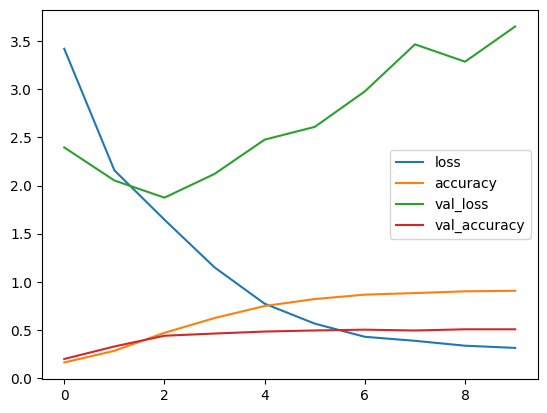

In [27]:
#plotting the old loss curves (without data augmentation)
pd.DataFrame(history_base.history).plot()

we can see that the old model (without the data augmentation layer has overfit a lot)
Since this is a human perception task, the human level performance in this case would be close to 100 percent (unless the image itself is very blurry and 
cannot be identitified). Thus the Bayes optimal error is then approximately 100 (using the human level performance as a proxy for Bayes optimal error) which
gives us an avoidable bias of ~5 percent and huge variance. Thus, we should try decreasing the variance (or overfitting)

for reducing the variance, we can try
1. Increasing the amount of training data
2. Changing the network architecture (changing the number of filters and the number of layers in the network)
3. using data augmentation

First, we try training it on more data and combine the data augmentation in this step (as the only possible way in this case to attain more data is to use data
augmentation). However, we will not be using data augmentation as we have used in the second model as I don't have the computational power to pass them through
the data augmentation layers (requires a lot of computation). We will use the Augmented data provided to us in the dataset

In [26]:
augmented_dir = "/home/linux/Tensorflow Notebooks/Animal Classification Dataset/Train Augmented/Train Augmented"
validation_dir = "/home/linux/Tensorflow Notebooks/Animal Classification Dataset/Validation Data/Validation Data"
test_dir = "/home/linux/Tensorflow Notebooks/Animal Classification Dataset/Testing Data/Testing Data"
augmented_data = tf.keras.utils.image_dataset_from_directory(directory = augmented_dir, label_mode = 'categorical', image_size = (224,224), shuffle = True, batch_size = 32)
validation_data = tf.keras.utils.image_dataset_from_directory(directory = validation_dir, label_mode = "categorical", image_size = (224,224), batch_size = 32)
test_data = tf.keras.utils.image_dataset_from_directory(directory = test_dir, label_mode = "categorical", batch_size = 32, image_size = (224,224))

Found 150000 files belonging to 15 classes.
Found 2000 files belonging to 15 classes.
Found 2404 files belonging to 15 classes.


In [27]:
#this should perform better as no we have 5 times the original data
base_model.load_weights(r"/home/linux/Tensorflow Notebooks/base_model_initial_weights.h5")
base_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")
history_augmented_base = base_model.fit(augmented_data, epochs = 10, steps_per_epoch = len(augmented_data), validation_data = validation_data,
                                        validation_steps = len(validation_data))

Epoch 1/10
4688/4688 [==============================] - 382s 81ms/step - loss: 3.0089 - accuracy: 0.1390 - val_loss: 2.5276 - val_accuracy: 0.1730
Epoch 2/10
4688/4688 [==============================] - 394s 84ms/step - loss: 1.8943 - accuracy: 0.3732 - val_loss: 2.3234 - val_accuracy: 0.2710
Epoch 3/10
4688/4688 [==============================] - 386s 82ms/step - loss: 1.4573 - accuracy: 0.5214 - val_loss: 2.7303 - val_accuracy: 0.2885
Epoch 4/10
4688/4688 [==============================] - 380s 81ms/step - loss: 1.0070 - accuracy: 0.6687 - val_loss: 3.4409 - val_accuracy: 0.2775
Epoch 5/10
4688/4688 [==============================] - 387s 82ms/step - loss: 0.6896 - accuracy: 0.7716 - val_loss: 4.4706 - val_accuracy: 0.2710
Epoch 6/10
4688/4688 [==============================] - 379s 81ms/step - loss: 0.5192 - accuracy: 0.8278 - val_loss: 4.9021 - val_accuracy: 0.2830
Epoch 7/10
4688/4688 [==============================] - 382s 82ms/step - loss: 0.4183 - accuracy: 0.8612 - val_loss: 5

In [ ]:
#now, we just reduce the model complexity by reducing the number of filters in the layers (no data_augmentation this time)
tf.random.set_seed(42)

reduced_model = tf.keras.Sequential()
reduced_model.add(tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, strides = 1, padding = "same", activation = "relu", input_shape = (224,224,3)))
reduced_model.add(tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
reduced_model.add(tf.keras.layers.MaxPool2D())
reduced_model.add(tf.keras.layers.Conv2D(filters = 20, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
reduced_model.add(tf.keras.layers.Conv2D(filters = 20, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
reduced_model.add(tf.keras.layers.MaxPool2D())
reduced_model.add(tf.keras.layers.Flatten())
reduced_model.add(tf.keras.layers.Dense(50, activation = "relu"))
reduced_model.add(tf.keras.layers.Dense(15, activation = "softmax"))

#compiling the model
reduced_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")
#saving the model weights to conduct later experiments
reduced_model.save_weights("Reduced_model_initial_weights.h5")

#fitting the model
history_reduced_model_no_augment = reduced_model.fit(train_data, epochs = 10, steps_per_epoch = len(train_data), validation_data = validation_data,
                                                     validation_steps = len(validation_data))

In [29]:
#using data augmentation this time with the reduced model
reduced_model.load_weights("Reduced_model_initial_weights.h5")
#compiling the model reinitializes the state of the optimizer function
reduced_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")
history_reduced_model_augment = reduced_model.fit(augmented_data, epochs = 5, steps_per_epoch = len(augmented_data), validation_data = validation_data,
                                                  validation_steps = len(validation_data))

Epoch 1/5
4688/4688 [==============================] - 308s 65ms/step - loss: 2.8265 - accuracy: 0.1859 - val_loss: 2.2990 - val_accuracy: 0.2445
Epoch 2/5
4688/4688 [==============================] - 297s 63ms/step - loss: 1.9956 - accuracy: 0.3394 - val_loss: 2.2285 - val_accuracy: 0.2995
Epoch 3/5
4688/4688 [==============================] - 302s 64ms/step - loss: 1.7030 - accuracy: 0.4372 - val_loss: 2.3640 - val_accuracy: 0.2940
Epoch 4/5
4688/4688 [==============================] - 301s 64ms/step - loss: 1.4721 - accuracy: 0.5132 - val_loss: 2.5614 - val_accuracy: 0.3020
Epoch 5/5
4688/4688 [==============================] - 308s 66ms/step - loss: 1.2911 - accuracy: 0.5692 - val_loss: 2.9254 - val_accuracy: 0.2805


We can see that the model is overfitting the data. So, for future experiments, epochs = 5. Also, It seems that the data augmentation is just hurting performance.
I somewhat reduces overfitting but overall leads to reduces validation accuracy. It is also possible that the validation set is very small itself and thus, subject
to such erratic behaviour. We can try using a bigger validation set. One thing is that we can try merging the validation and the test set as we do not have to
actually report the model's accuracy anywhere. So we can do this to get a bigger validation set.
We can also try normalizing the input data as that can improve learning. and lead to better generalization.

Here we try Normalizing the data and also combine the test_data and the validation_data

In [8]:
#Now, we also try normalization instead of simply passing the data
tf.random.set_seed(42)

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Input(shape = (224,224,3)))
model3.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale = 1.0/255.0))
model3.add(tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model3.add(tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model3.add(tf.keras.layers.MaxPool2D())
model3.add(tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model3.add(tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model3.add(tf.keras.layers.MaxPool2D())
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(50, activation = "relu"))
model3.add(tf.keras.layers.Dense(15, activation = "softmax"))

model3.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")
model3.save_weights("Normalized_reduced_model_initial_weights.h5")
history = model3.fit(train_data, epochs = 5, steps_per_epoch = len(train_data), validation_data = validation_data, validation_steps = len(validation_data))

Epoch 1/5
938/938 [==============================] - 64s 65ms/step - loss: 2.0931 - accuracy: 0.3251 - val_loss: 1.9237 - val_accuracy: 0.3899
Epoch 2/5
938/938 [==============================] - 62s 66ms/step - loss: 1.4850 - accuracy: 0.5282 - val_loss: 1.7416 - val_accuracy: 0.4512
Epoch 3/5
938/938 [==============================] - 62s 66ms/step - loss: 1.0381 - accuracy: 0.6762 - val_loss: 2.0026 - val_accuracy: 0.4696
Epoch 4/5
938/938 [==============================] - 62s 66ms/step - loss: 0.6272 - accuracy: 0.8048 - val_loss: 2.3068 - val_accuracy: 0.5014
Epoch 5/5
938/938 [==============================] - 63s 67ms/step - loss: 0.3456 - accuracy: 0.8926 - val_loss: 3.2209 - val_accuracy: 0.5050


So we can see that the model has overfit a lot but the validation accuracy has improved a lot. So remember to use normalization.
Now we can try using this neural network on the augmented dataset.

In [39]:
model3.load_weights("Normalized_reduced_model_initial_weights.h5")
model3.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")
history_augmented = model3.fit(augmented_data, epochs = 5, steps_per_epoch = len(augmented_data), validation_data = validation_data, 
                               validation_steps = len(validation_data))

Epoch 1/5
4688/4688 [==============================] - 289s 61ms/step - loss: 2.0387 - accuracy: 0.3278 - val_loss: 2.1699 - val_accuracy: 0.3208
Epoch 2/5
4688/4688 [==============================] - 285s 61ms/step - loss: 1.6818 - accuracy: 0.4516 - val_loss: 2.1373 - val_accuracy: 0.3454
Epoch 3/5
4688/4688 [==============================] - 286s 61ms/step - loss: 1.4879 - accuracy: 0.5122 - val_loss: 2.2143 - val_accuracy: 0.3617
Epoch 4/5
4688/4688 [==============================] - 279s 60ms/step - loss: 1.3297 - accuracy: 0.5632 - val_loss: 2.5374 - val_accuracy: 0.3311
Epoch 5/5
4688/4688 [==============================] - 283s 60ms/step - loss: 1.2078 - accuracy: 0.6007 - val_loss: 2.7084 - val_accuracy: 0.3279


we should try improving the architecture of the model as the performace is not satisfactory

In [6]:
#using mixed precision training to improve the model training time
from keras import mixed_precision
mixed_precision.set_global_policy(policy = "mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [10]:
#New architecture
tf.random.set_seed(42)
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Input(shape = (224,224,3)))
model4.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale = 1.0/255.0))
model4.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu", input_shape = (224,224,3)))
model4.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model4.add(tf.keras.layers.MaxPool2D())
model4.add(tf.keras.layers.Conv2D(filters = 25, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model4.add(tf.keras.layers.Conv2D(filters = 25, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model4.add(tf.keras.layers.MaxPool2D())
model4.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model4.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model4.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model4.add(tf.keras.layers.MaxPool2D())
model4.add(tf.keras.layers.Flatten())
model4.add(tf.keras.layers.Dense(1000, activation = "relu"))
model4.add(tf.keras.layers.Dense(500, activation = "relu"))
model4.add(tf.keras.layers.Dense(15))
model4.add(tf.keras.layers.Activation("softmax", dtype = tf.float32))

model4.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")
model4.fit(train_data, epochs = 5, steps_per_epoch = len(train_data), validation_data = validation_data, validation_steps = len(validation_data))

Epoch 1/5
938/938 [==============================] - 183s 154ms/step - loss: 2.2903 - accuracy: 0.2260 - val_loss: 2.0320 - val_accuracy: 0.3540
Epoch 2/5
938/938 [==============================] - 125s 133ms/step - loss: 1.6807 - accuracy: 0.4512 - val_loss: 1.7472 - val_accuracy: 0.4619
Epoch 3/5
938/938 [==============================] - 125s 133ms/step - loss: 1.1241 - accuracy: 0.6369 - val_loss: 1.9922 - val_accuracy: 0.5059
Epoch 4/5
938/938 [==============================] - 125s 133ms/step - loss: 0.5579 - accuracy: 0.8224 - val_loss: 2.7680 - val_accuracy: 0.5050
Epoch 5/5
938/938 [==============================] - 125s 133ms/step - loss: 0.2516 - accuracy: 0.9219 - val_loss: 3.1450 - val_accuracy: 0.5213


In [7]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

In [7]:
#reducing the model complexity
tf.random.set_seed(42)
model5 = tf.keras.Sequential()
model5.add(tf.keras.layers.Input(shape = (224,224,3)))
model5.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale = 1.0/255.0))
model5.add(tf.keras.layers.Conv2D(filters = 5, kernel_size = 3, strides = 1, padding = "same", activation = "relu", input_shape = (224,224,3)))
model5.add(tf.keras.layers.Conv2D(filters = 5, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model5.add(tf.keras.layers.MaxPool2D())
model5.add(tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model5.add(tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model5.add(tf.keras.layers.MaxPool2D())
model5.add(tf.keras.layers.Conv2D(filters = 20, kernel_size = 3, strides = 1, padding = "valid", activation = "relu"))
model5.add(tf.keras.layers.Conv2D(filters = 20, kernel_size = 3, strides = 1, padding = "valid", activation = "relu"))
model5.add(tf.keras.layers.MaxPool2D())
model5.add(tf.keras.layers.Flatten())
model5.add(tf.keras.layers.Dense(25, activation = "relu"))
model5.add(tf.keras.layers.Dense(25, activation = "relu"))
model5.add(tf.keras.layers.Dense(15))
model5.add(tf.keras.layers.Activation("softmax", dtype = tf.float32))

model5.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")
model5.fit(train_data, epochs = 10, steps_per_epoch = len(train_data), validation_data = validation_data, validation_steps = len(validation_data))

Epoch 1/10
938/938 [==============================] - 59s 54ms/step - loss: 2.2575 - accuracy: 0.2356 - val_loss: 2.1878 - val_accuracy: 0.2943
Epoch 2/10
938/938 [==============================] - 56s 60ms/step - loss: 1.8519 - accuracy: 0.3865 - val_loss: 2.0092 - val_accuracy: 0.3803
Epoch 3/10
938/938 [==============================] - 57s 61ms/step - loss: 1.5875 - accuracy: 0.4798 - val_loss: 1.8870 - val_accuracy: 0.4137
Epoch 4/10
938/938 [==============================] - 59s 63ms/step - loss: 1.3968 - accuracy: 0.5486 - val_loss: 1.9376 - val_accuracy: 0.4421
Epoch 5/10
938/938 [==============================] - 54s 57ms/step - loss: 1.2302 - accuracy: 0.6005 - val_loss: 1.9163 - val_accuracy: 0.4600
Epoch 6/10
938/938 [==============================] - 58s 62ms/step - loss: 1.0626 - accuracy: 0.6550 - val_loss: 1.9955 - val_accuracy: 0.4687
Epoch 7/10
938/938 [==============================] - 57s 60ms/step - loss: 0.9033 - accuracy: 0.7094 - val_loss: 2.1767 - val_accuracy:

As we can see, the model shows overfitting as the validation loss has started increasing but it also shows underfitting as the avoidable bias is very large (about 18 percent). Thus, this model is not expressive enough to actually capture the patterns. This is also representative of the fact that bias and variance are actually independent terms. Now, we try with a more complex model

In [ ]:
#using transfer learning once to check how well can we do
tf.random.set_seed(42)
base_model = tf.keras.applications.EfficientNetB7(include_top = False)
base_model.trainable = False

#no need to normalize the inputs because efficientnets have a normalization layer
inputs = tf.keras.layers.Input(shape = (224,224,3))
x = base_model(inputs, training = False)
x = tf.keras.layers.Dense(100, activation = "relu")(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(15, activation = "softmax")(x)

model7 = tf.keras.Model(inputs, outputs)
model7.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")
model7.fit(train_data, epochs = 10, validation_data = validation_data, validation_steps = len(validation_data), steps_per_epoch = len(train_data))

In [15]:
#Creating another model. Also we will use a deeper network this time around.

model8 = tf.keras.Sequential()
model8.add(tf.keras.layers.Input(shape = (224,224,3)))
model8.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0))
model8.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu", input_shape = (224,224,3)))
model8.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model8.add(tf.keras.layers.MaxPool2D())
model8.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model8.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model8.add(tf.keras.layers.MaxPool2D())
model8.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model8.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model8.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model8.add(tf.keras.layers.MaxPool2D())
model8.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model8.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model8.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model8.add(tf.keras.layers.MaxPool2D())
model8.add(tf.keras.layers.Flatten())
model8.add(tf.keras.layers.Dense(100, activation = "relu"))
model8.add(tf.keras.layers.Dense(100, activation = "relu"))
model8.add(tf.keras.layers.Dense(15))
model8.add(tf.keras.layers.Activation("softmax", dtype = tf.float32))

model8.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")
history = model8.fit(train_data, epochs = 3, steps_per_epoch = len(train_data), validation_data = validation_data, validation_steps = len(validation_data))

Epoch 1/3
938/938 [==============================] - 175s 141ms/step - loss: 2.3950 - accuracy: 0.1942 - val_loss: 2.2152 - val_accuracy: 0.2884
Epoch 2/3
938/938 [==============================] - 115s 122ms/step - loss: 1.9001 - accuracy: 0.3718 - val_loss: 1.9850 - val_accuracy: 0.3703
Epoch 3/3
938/938 [==============================] - 113s 121ms/step - loss: 1.5627 - accuracy: 0.4953 - val_loss: 1.7934 - val_accuracy: 0.4462


We can see that the model is not able to learn anything. Could be because we are using a deeper network due to which, the model is sufferring from vanishing gradients. So, we should implement residual blocks in this network and also use BatchNormalization to increase training speed. We can also try using Dropout regularization but that will be done after gauging the performance of this model.

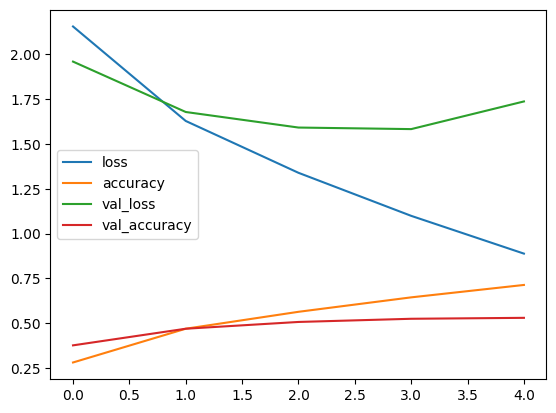

In [ ]:
pd.DataFrame(history.history).plot()
plt.show()

# **Deep CNN with Residual Connections**

In [8]:
from keras.layers import Input, Dense, Conv2D, MaxPool2D, GlobalAveragePooling2D

In [20]:
# Implementing a Deep CNN and also implementing Residual Connections to solve the problem of vanishing gradients. For this, we will have to use the Functional API

tf.random.set_seed(42)

inputs = Input(shape = (224,224,3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)(inputs)

def resblock(x, kernelsize, filters):
    fx = Conv2D(filters, kernelsize, activation='relu', padding='same')(x)
    fx = tf.keras.layers.BatchNormalization()(fx)
    fx = Conv2D(filters, kernelsize, padding='same')(fx)
    out = tf.keras.layers.Add()([x,fx])
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.BatchNormalization()(out)
    return out

model9 = tf.keras.Sequential()
model9.add(Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu", input_shape = (224,224,3)))
model9.add(Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model9.add(tf.keras.layers.BatchNormalization())
model9.add(MaxPool2D())
model9.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model9.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model9.add(MaxPool2D())
model9.add(tf.keras.layers.BatchNormalization())
model9.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model9.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model9.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model9.add(tf.keras.layers.BatchNormalization())

x = model9(x)
x = resblock(x, 3, 32)

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation = "relu")(x)
x = Dense(256, activation = "relu")(x)
x = Dense(15)(x)
outputs = tf.keras.layers.Activation("softmax", dtype = tf.float32)(x)

model_final = tf.keras.Model(inputs, outputs)
model_final.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")
history = model_final.fit(train_data, epochs = 8, steps_per_epoch = len(train_data), validation_data = validation_data, validation_steps = len(validation_data))

Epoch 1/8
938/938 [==============================] - 142s 142ms/step - loss: 2.0720 - accuracy: 0.3129 - val_loss: 1.8121 - val_accuracy: 0.3935
Epoch 2/8
938/938 [==============================] - 130s 139ms/step - loss: 1.5688 - accuracy: 0.4835 - val_loss: 2.1225 - val_accuracy: 0.3445
Epoch 3/8
938/938 [==============================] - 132s 140ms/step - loss: 1.3143 - accuracy: 0.5668 - val_loss: 1.9706 - val_accuracy: 0.3965
Epoch 4/8
938/938 [==============================] - 135s 144ms/step - loss: 1.1747 - accuracy: 0.6148 - val_loss: 1.5248 - val_accuracy: 0.5195
Epoch 5/8
938/938 [==============================] - 130s 138ms/step - loss: 1.0649 - accuracy: 0.6533 - val_loss: 1.5645 - val_accuracy: 0.5293
Epoch 6/8
938/938 [==============================] - 131s 139ms/step - loss: 0.9705 - accuracy: 0.6838 - val_loss: 1.7476 - val_accuracy: 0.4678
Epoch 7/8
938/938 [==============================] - 133s 142ms/step - loss: 0.9047 - accuracy: 0.7074 - val_loss: 1.3957 - val_ac

In [17]:
# Implementing a Deep CNN and also implementing Residual Connections to solve the problem of vanishing gradients. For this, we will have to use the Functional API

tf.random.set_seed(42)

inputs = Input(shape = (224,224,3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)(inputs)

def resblock(x, kernelsize, filters):
    fx = Conv2D(filters, kernelsize, activation='relu', padding='same')(x)
    fx = Conv2D(filters, kernelsize, activation='relu', padding='same')(fx)
    fx = tf.keras.layers.BatchNormalization()(fx)
    fx = Conv2D(filters, kernelsize, padding='same')(fx)
    out = tf.keras.layers.Add()([x,fx])
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.BatchNormalization()(out)
    return out

model10 = tf.keras.Sequential()
model10.add(Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu", input_shape = (224,224,3)))
model10.add(Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model10.add(tf.keras.layers.BatchNormalization())
model10.add(MaxPool2D())
model10.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model10.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model10.add(MaxPool2D())
model10.add(tf.keras.layers.BatchNormalization())
model10.add(Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model10.add(Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model10.add(Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model10.add(tf.keras.layers.BatchNormalization())

x = model10(x)
x = resblock(x, 3, 128)
x = resblock(x, 3, 128)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation = "relu")(x)
x = Dense(256, activation = "relu")(x)
x = Dense(15)(x)
outputs = tf.keras.layers.Activation("softmax", dtype = tf.float32)(x)

model_final10= tf.keras.Model(inputs, outputs)
model_final10.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")
history = model_final10.fit(train_data, epochs = 8, steps_per_epoch = len(train_data), validation_data = validation_data, validation_steps = len(validation_data))

Epoch 1/8
938/938 [==============================] - 294s 302ms/step - loss: 2.1035 - accuracy: 0.3023 - val_loss: 2.1977 - val_accuracy: 0.3011
Epoch 2/8
938/938 [==============================] - 285s 303ms/step - loss: 1.6431 - accuracy: 0.4559 - val_loss: 2.0584 - val_accuracy: 0.3837
Epoch 3/8
938/938 [==============================] - 282s 301ms/step - loss: 1.4213 - accuracy: 0.5303 - val_loss: 1.6886 - val_accuracy: 0.4412
Epoch 4/8
938/938 [==============================] - 286s 305ms/step - loss: 1.2441 - accuracy: 0.5914 - val_loss: 1.7603 - val_accuracy: 0.4532
Epoch 5/8
938/938 [==============================] - 286s 305ms/step - loss: 1.0985 - accuracy: 0.6402 - val_loss: 1.5996 - val_accuracy: 0.5123
Epoch 6/8
938/938 [==============================] - 286s 305ms/step - loss: 0.9861 - accuracy: 0.6804 - val_loss: 1.6339 - val_accuracy: 0.5184
Epoch 7/8
938/938 [==============================] - 282s 301ms/step - loss: 0.8953 - accuracy: 0.7098 - val_loss: 1.4771 - val_ac

In [9]:
#creating a checkpoint callback to save the best weights of the model
checkpoint_directory = "Tensorflow Checkpoints/Deep Model/model11.chkpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_directory, save_weights_only = True, save_best_only = True)

In [10]:
# Implementing a Deep CNN and also implementing Residual Connections to solve the problem of vanishing gradients. For this, we will have to use the Functional API

tf.random.set_seed(42)

inputs = Input(shape = (224,224,3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)(inputs)

def resblock(x, kernelsize, filters):
    fx = Conv2D(filters, kernelsize, activation='relu', padding='same')(x)
    fx = tf.keras.layers.BatchNormalization()(fx)
    fx = Conv2D(filters, kernelsize, padding='same')(fx)
    out = tf.keras.layers.Add()([x,fx])
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.BatchNormalization()(out)
    return out

model11 = tf.keras.Sequential()
model11.add(Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu", input_shape = (224,224,3)))
model11.add(Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model11.add(tf.keras.layers.BatchNormalization())
model11.add(MaxPool2D())
model11.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model11.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model11.add(MaxPool2D())
model11.add(tf.keras.layers.BatchNormalization())
model11.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model11.add(Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model11.add(Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model11.add(tf.keras.layers.BatchNormalization())

x = model11(x)
x = resblock(x, 3, 64)

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation = "relu")(x)
x = Dense(256, activation = "relu")(x)
x = Dense(15)(x)
outputs = tf.keras.layers.Activation("softmax", dtype = tf.float32)(x)

model_final11 = tf.keras.Model(inputs, outputs)
model_final11.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")
history = model_final11.fit(train_data, epochs = 20, steps_per_epoch = len(train_data), validation_data = validation_data, validation_steps = len(validation_data),
                            callbacks = checkpoint_callback)

Epoch 1/20
938/938 [==============================] - 222s 185ms/step - loss: 1.9966 - accuracy: 0.3398 - val_loss: 2.4234 - val_accuracy: 0.2439
Epoch 2/20
938/938 [==============================] - 151s 161ms/step - loss: 1.4824 - accuracy: 0.5115 - val_loss: 2.1255 - val_accuracy: 0.3433
Epoch 3/20
938/938 [==============================] - 150s 159ms/step - loss: 1.2537 - accuracy: 0.5854 - val_loss: 2.2443 - val_accuracy: 0.3349
Epoch 4/20
938/938 [==============================] - 152s 162ms/step - loss: 1.1095 - accuracy: 0.6342 - val_loss: 1.8838 - val_accuracy: 0.4294
Epoch 5/20
938/938 [==============================] - 153s 163ms/step - loss: 0.9891 - accuracy: 0.6748 - val_loss: 3.1615 - val_accuracy: 0.3713
Epoch 6/20
938/938 [==============================] - 158s 168ms/step - loss: 0.8974 - accuracy: 0.7056 - val_loss: 1.4850 - val_accuracy: 0.5359
Epoch 7/20
938/938 [==============================] - 155s 165ms/step - loss: 0.8221 - accuracy: 0.7350 - val_loss: 1.3357 -

# **Woohoo.. we have finally cracked the 70 percent accuracy target**
We should now try to fit the more complex model for same number of epochs and then check the result if anything improves or not. Since we have not overfit the dataset (to a great extent) yet, I expect to see some improvement.

In [9]:
# Implementing a Deep CNN and also implementing Residual Connections to solve the problem of vanishing gradients. For this, we will have to use the Functional API

tf.random.set_seed(42)

inputs = Input(shape = (224,224,3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)(inputs)

def resblock(x, kernelsize, filters):
    fx = Conv2D(filters, kernelsize, activation='relu', padding='same')(x)
    fx = Conv2D(filters, kernelsize, activation='relu', padding='same')(fx)
    fx = tf.keras.layers.BatchNormalization()(fx)
    fx = Conv2D(filters, kernelsize, padding='same')(fx)
    out = tf.keras.layers.Add()([x,fx])
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.BatchNormalization()(out)
    return out

model12 = tf.keras.Sequential()
model12.add(Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu", input_shape = (224,224,3)))
model12.add(Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model12.add(tf.keras.layers.BatchNormalization())
model12.add(MaxPool2D())
model12.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model12.add(Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model12.add(MaxPool2D())
model12.add(tf.keras.layers.BatchNormalization())
model12.add(Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model12.add(Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model12.add(Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", activation = "relu"))
model12.add(tf.keras.layers.BatchNormalization())

x = model12(x)
x = resblock(x, 3, 128)
x = resblock(x, 3, 128)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation = "relu")(x)
x = Dense(256, activation = "relu")(x)
x = Dense(15)(x)
outputs = tf.keras.layers.Activation("softmax", dtype = tf.float32)(x)

#creating a checkpoint callback to save the best weights of the model

model_final12= tf.keras.Model(inputs, outputs)
model_final12.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")

In [10]:
# Till now, the best validation accuracy that we have achieved is 71.82 percent which is not bad considering the depth of the model
# Now let us load those weights and make predictions (to make a confusion matrix)
model_final12.load_weights("Tensorflow Checkpoints/Deep Model/model12.chkpt")
model_final12.evaluate(test_data)

76/76 [==============================] - 26s 124ms/step - loss: 1.0297 - accuracy: 0.7200


[1.0297060012817383, 0.7200499176979065]

In [11]:
#finally achieved an accuracy of 72 percent. Noice!
#Now, let us make preditions and compare them to the actual labels to make a confusion matrix
model_preds = model_final12.predict(validation_data)
print(model_preds[1])

139/139 [==============================] - 20s 144ms/step
[9.8211688e-01 3.5553990e-04 1.3600613e-04 3.9201250e-04 1.3207938e-04
 7.9630281e-06 2.3116290e-03 9.3658309e-05 1.4664938e-03 1.8628959e-03
 3.5902896e-04 4.7108415e-03 2.4583144e-03 3.2983464e-03 2.9822739e-04]


In [12]:
#Now, we have the prediction probabilities. We can take the index where the value is maximum and treat that as the prediction
pred_index = tf.argmax(model_preds, axis =1)
print(pred_index[:10])
#and now we can assign each class its class label by
pred_class = []
for index in pred_index:
  pred_class.append(class_names[index])
pred_class = np.array(pred_class)

tf.Tensor([ 0  0  1  0  0  0  1 12  4  1], shape=(10,), dtype=int64)


In [13]:
#thus, each value represents a class.
print(pred_class[:10])
#thus, these are the predicted classes for the first 10 examples

['Beetle' 'Beetle' 'Butterfly' 'Beetle' 'Beetle' 'Beetle' 'Butterfly'
 'Spider' 'Dog' 'Butterfly']


In [14]:
y_labels = []
for images,labels in validation_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [15]:
print(y_labels[:10])
y_test = np.array(y_labels)
y_pred = pred_index.numpy()
label_names = class_names

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [16]:
import itertools
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=16, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  plt.xticks(rotation = 75)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

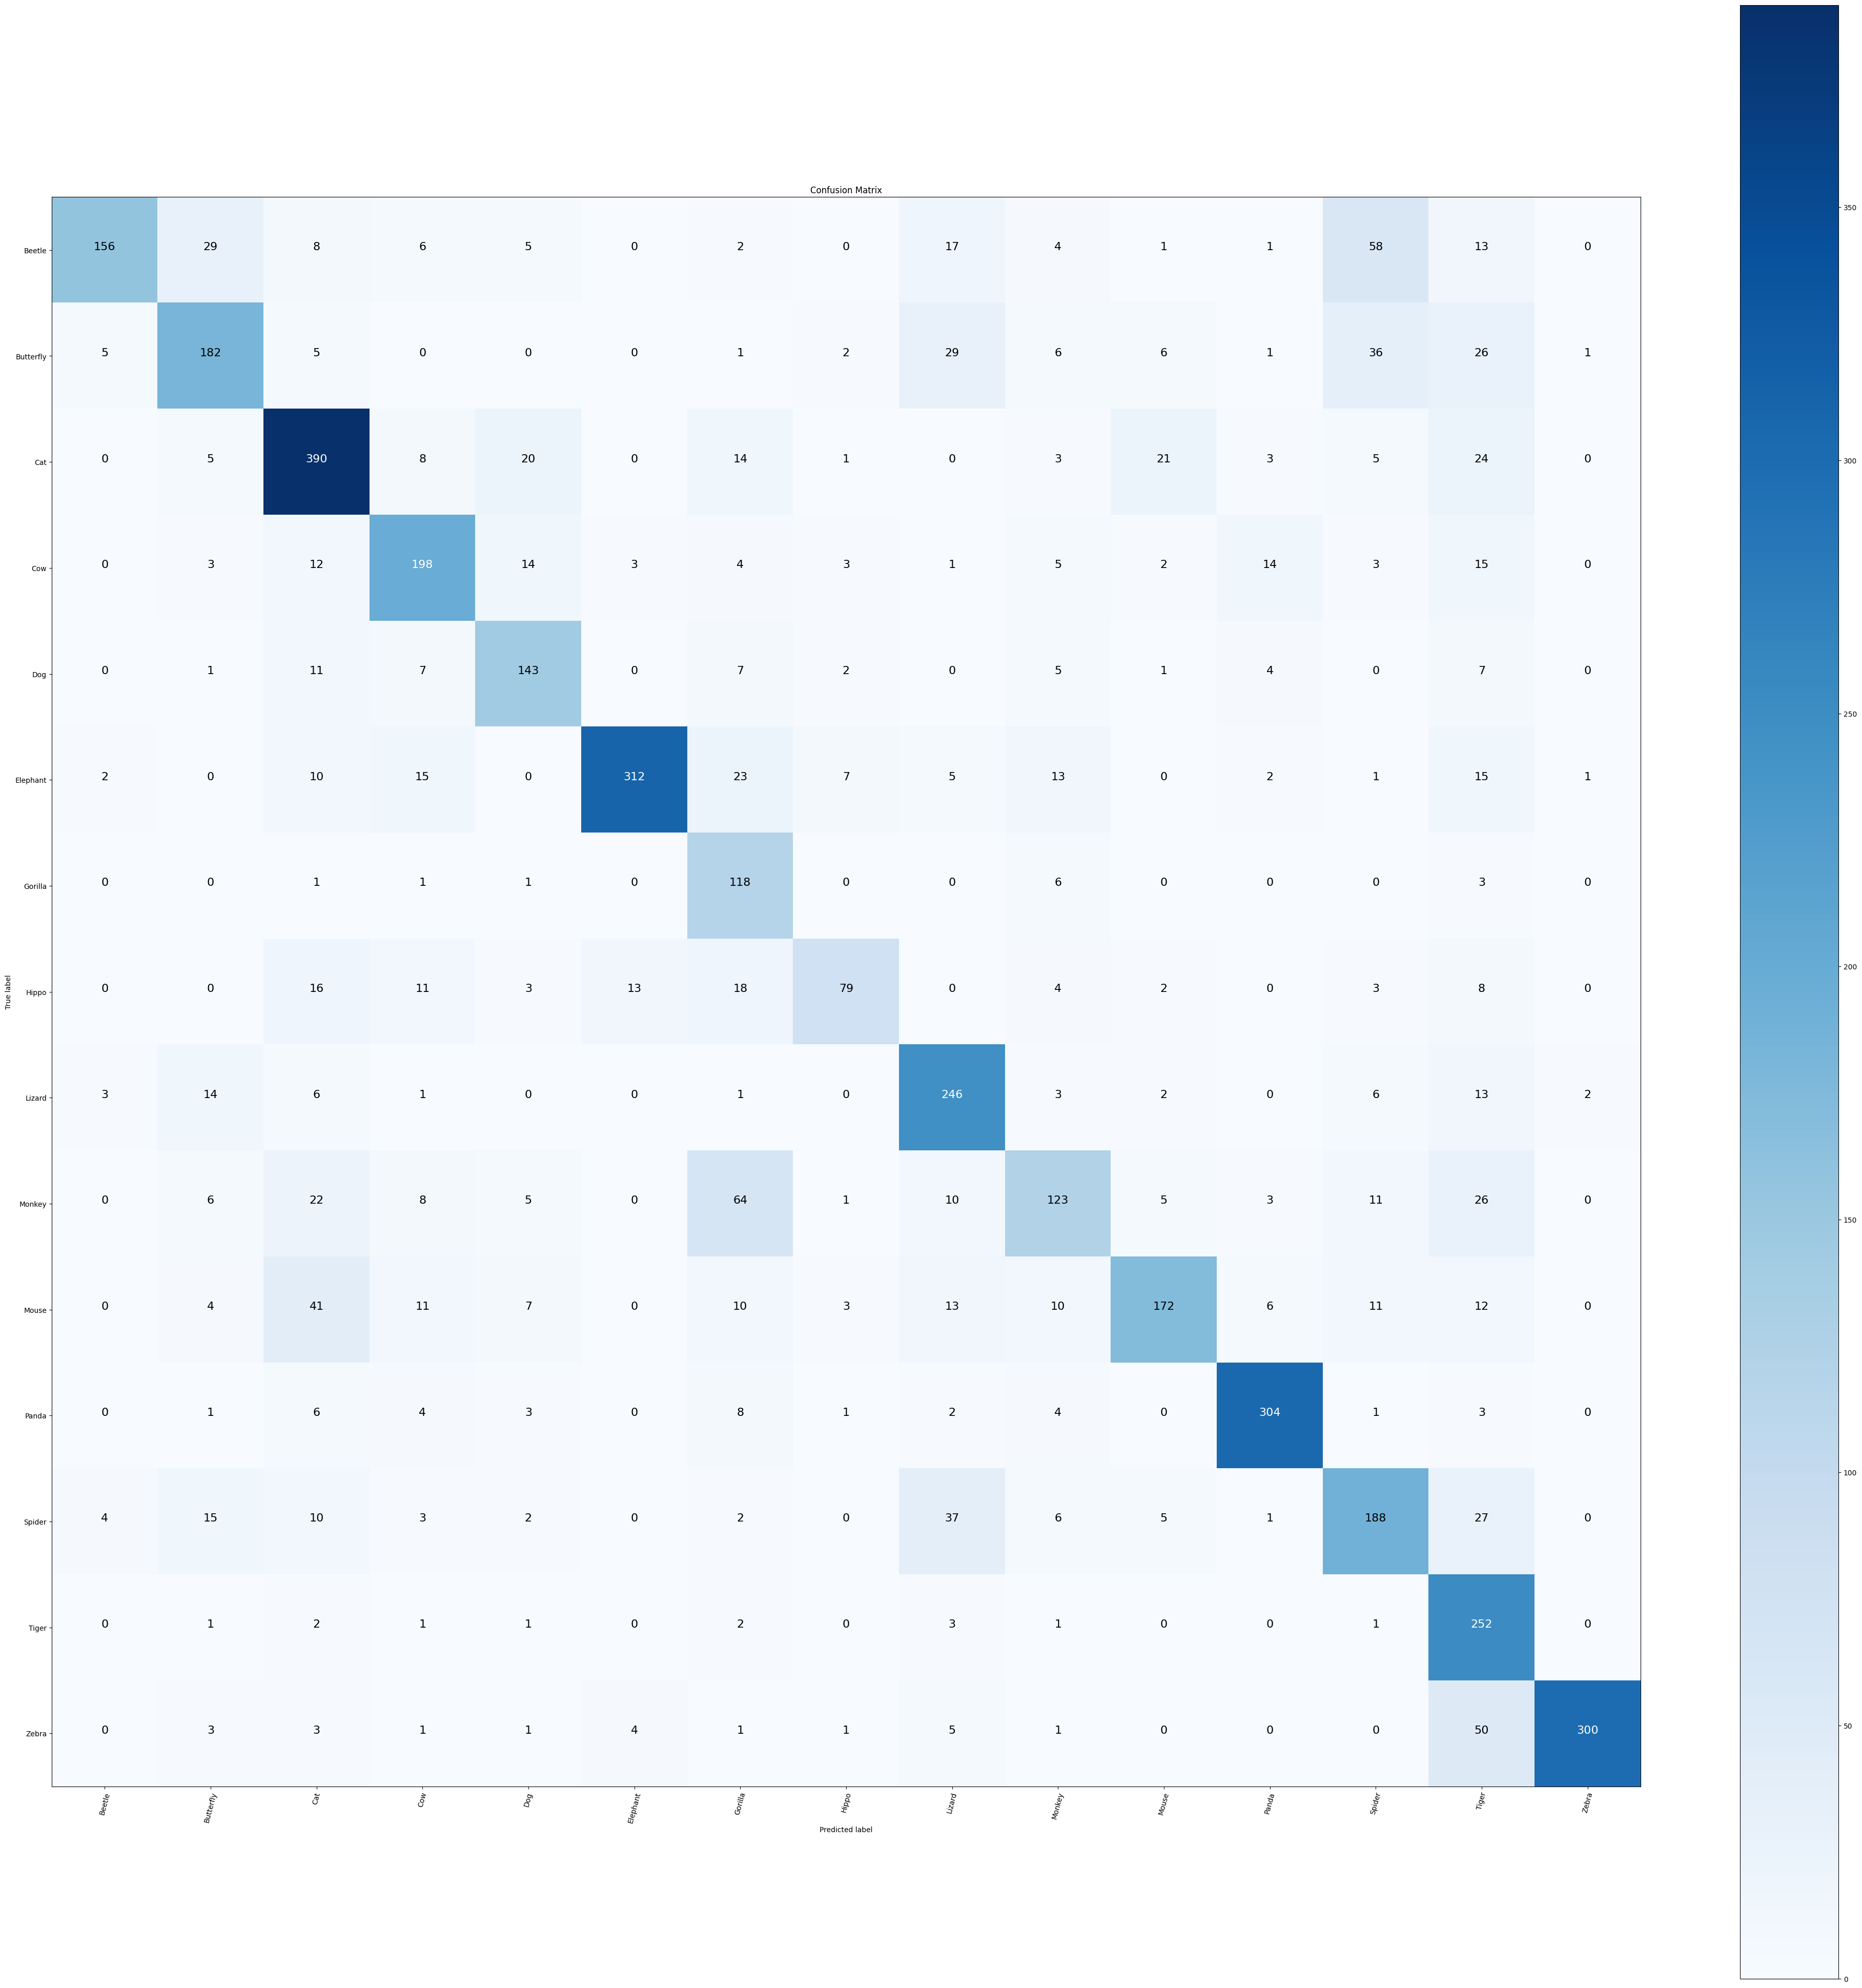

In [17]:
make_confusion_matrix(y_true = y_labels, y_pred =pred_index, classes = label_names, figsize =(50,50))

In [19]:
#let us train an efficient net model on the same data and plot the confusion matrix for that
#using transfer learning once to check how well can we do
tf.random.set_seed(42)
base_model = tf.keras.applications.EfficientNetB3(include_top = False)
base_model.trainable = False

#no need to normalize the inputs because efficientnets have a normalization layer
inputs = tf.keras.layers.Input(shape = (224,224,3))
x = base_model(inputs, training = False)
x = tf.keras.layers.Dense(100, activation = "relu")(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(15)(x)
outputs = tf.keras.layers.Activation("softmax", dtype = tf.float32)(x)

model7 = tf.keras.Model(inputs, outputs)
model7.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")
model7.fit(train_data, epochs = 5, validation_data = validation_data, validation_steps = len(validation_data), steps_per_epoch = len(train_data))

Epoch 1/5
938/938 [==============================] - 349s 356ms/step - loss: 0.1413 - accuracy: 0.9650 - val_loss: 0.1062 - val_accuracy: 0.9714
Epoch 2/5
938/938 [==============================] - 336s 358ms/step - loss: 0.0429 - accuracy: 0.9884 - val_loss: 0.1200 - val_accuracy: 0.9684
Epoch 3/5
938/938 [==============================] - 336s 358ms/step - loss: 0.0190 - accuracy: 0.9960 - val_loss: 0.1284 - val_accuracy: 0.9666
Epoch 4/5
938/938 [==============================] - 333s 355ms/step - loss: 0.0101 - accuracy: 0.9982 - val_loss: 0.1659 - val_accuracy: 0.9621
Epoch 5/5
938/938 [==============================] - 337s 359ms/step - loss: 0.0083 - accuracy: 0.9983 - val_loss: 0.1595 - val_accuracy: 0.9650


In [10]:
#using fine tuning to furthur improve the performance of the model
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

#recompiling the model and training for 5 more epochs
model7.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")
model7.fit(train_data, epochs= 3, validation_data = test_data, steps_per_epoch = len(train_data), validation_steps = len(test_data))

Epoch 1/3
938/938 [==============================] - 405s 409ms/step - loss: 0.0154 - accuracy: 0.9956 - val_loss: 0.1453 - val_accuracy: 0.9646
Epoch 2/3
938/938 [==============================] - 387s 413ms/step - loss: 0.0077 - accuracy: 0.9977 - val_loss: 0.1971 - val_accuracy: 0.9613
Epoch 3/3
938/938 [==============================] - 385s 410ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.1814 - val_accuracy: 0.9630


In [20]:
model_preds = model7.predict(validation_data)
print(model_preds[1])
pred_index = tf.argmax(model_preds, axis =1)
print(pred_index[:10])
#and now we can assign each class its class label by
pred_class = []
for index in pred_index:
  pred_class.append(class_names[index])
pred_class = np.array(pred_class)
y_labels = []
for images,labels in validation_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_test = np.array(y_labels)
y_pred = pred_index.numpy()

139/139 [==============================] - 45s 304ms/step
[9.9999988e-01 5.1302695e-08 2.5147814e-11 1.3466684e-08 5.4190108e-10
 4.1151362e-09 8.1612029e-08 1.4305105e-09 8.4519609e-09 6.3851552e-10
 3.7978856e-10 8.8748964e-09 2.6208540e-09 6.2975125e-11 5.7013022e-10]
tf.Tensor([0 0 0 0 0 0 0 0 0 0], shape=(10,), dtype=int64)


In [21]:
model7.evaluate(test_data)

76/76 [==============================] - 23s 307ms/step - loss: 0.2009 - accuracy: 0.9609


[0.20092454552650452, 0.9608985185623169]

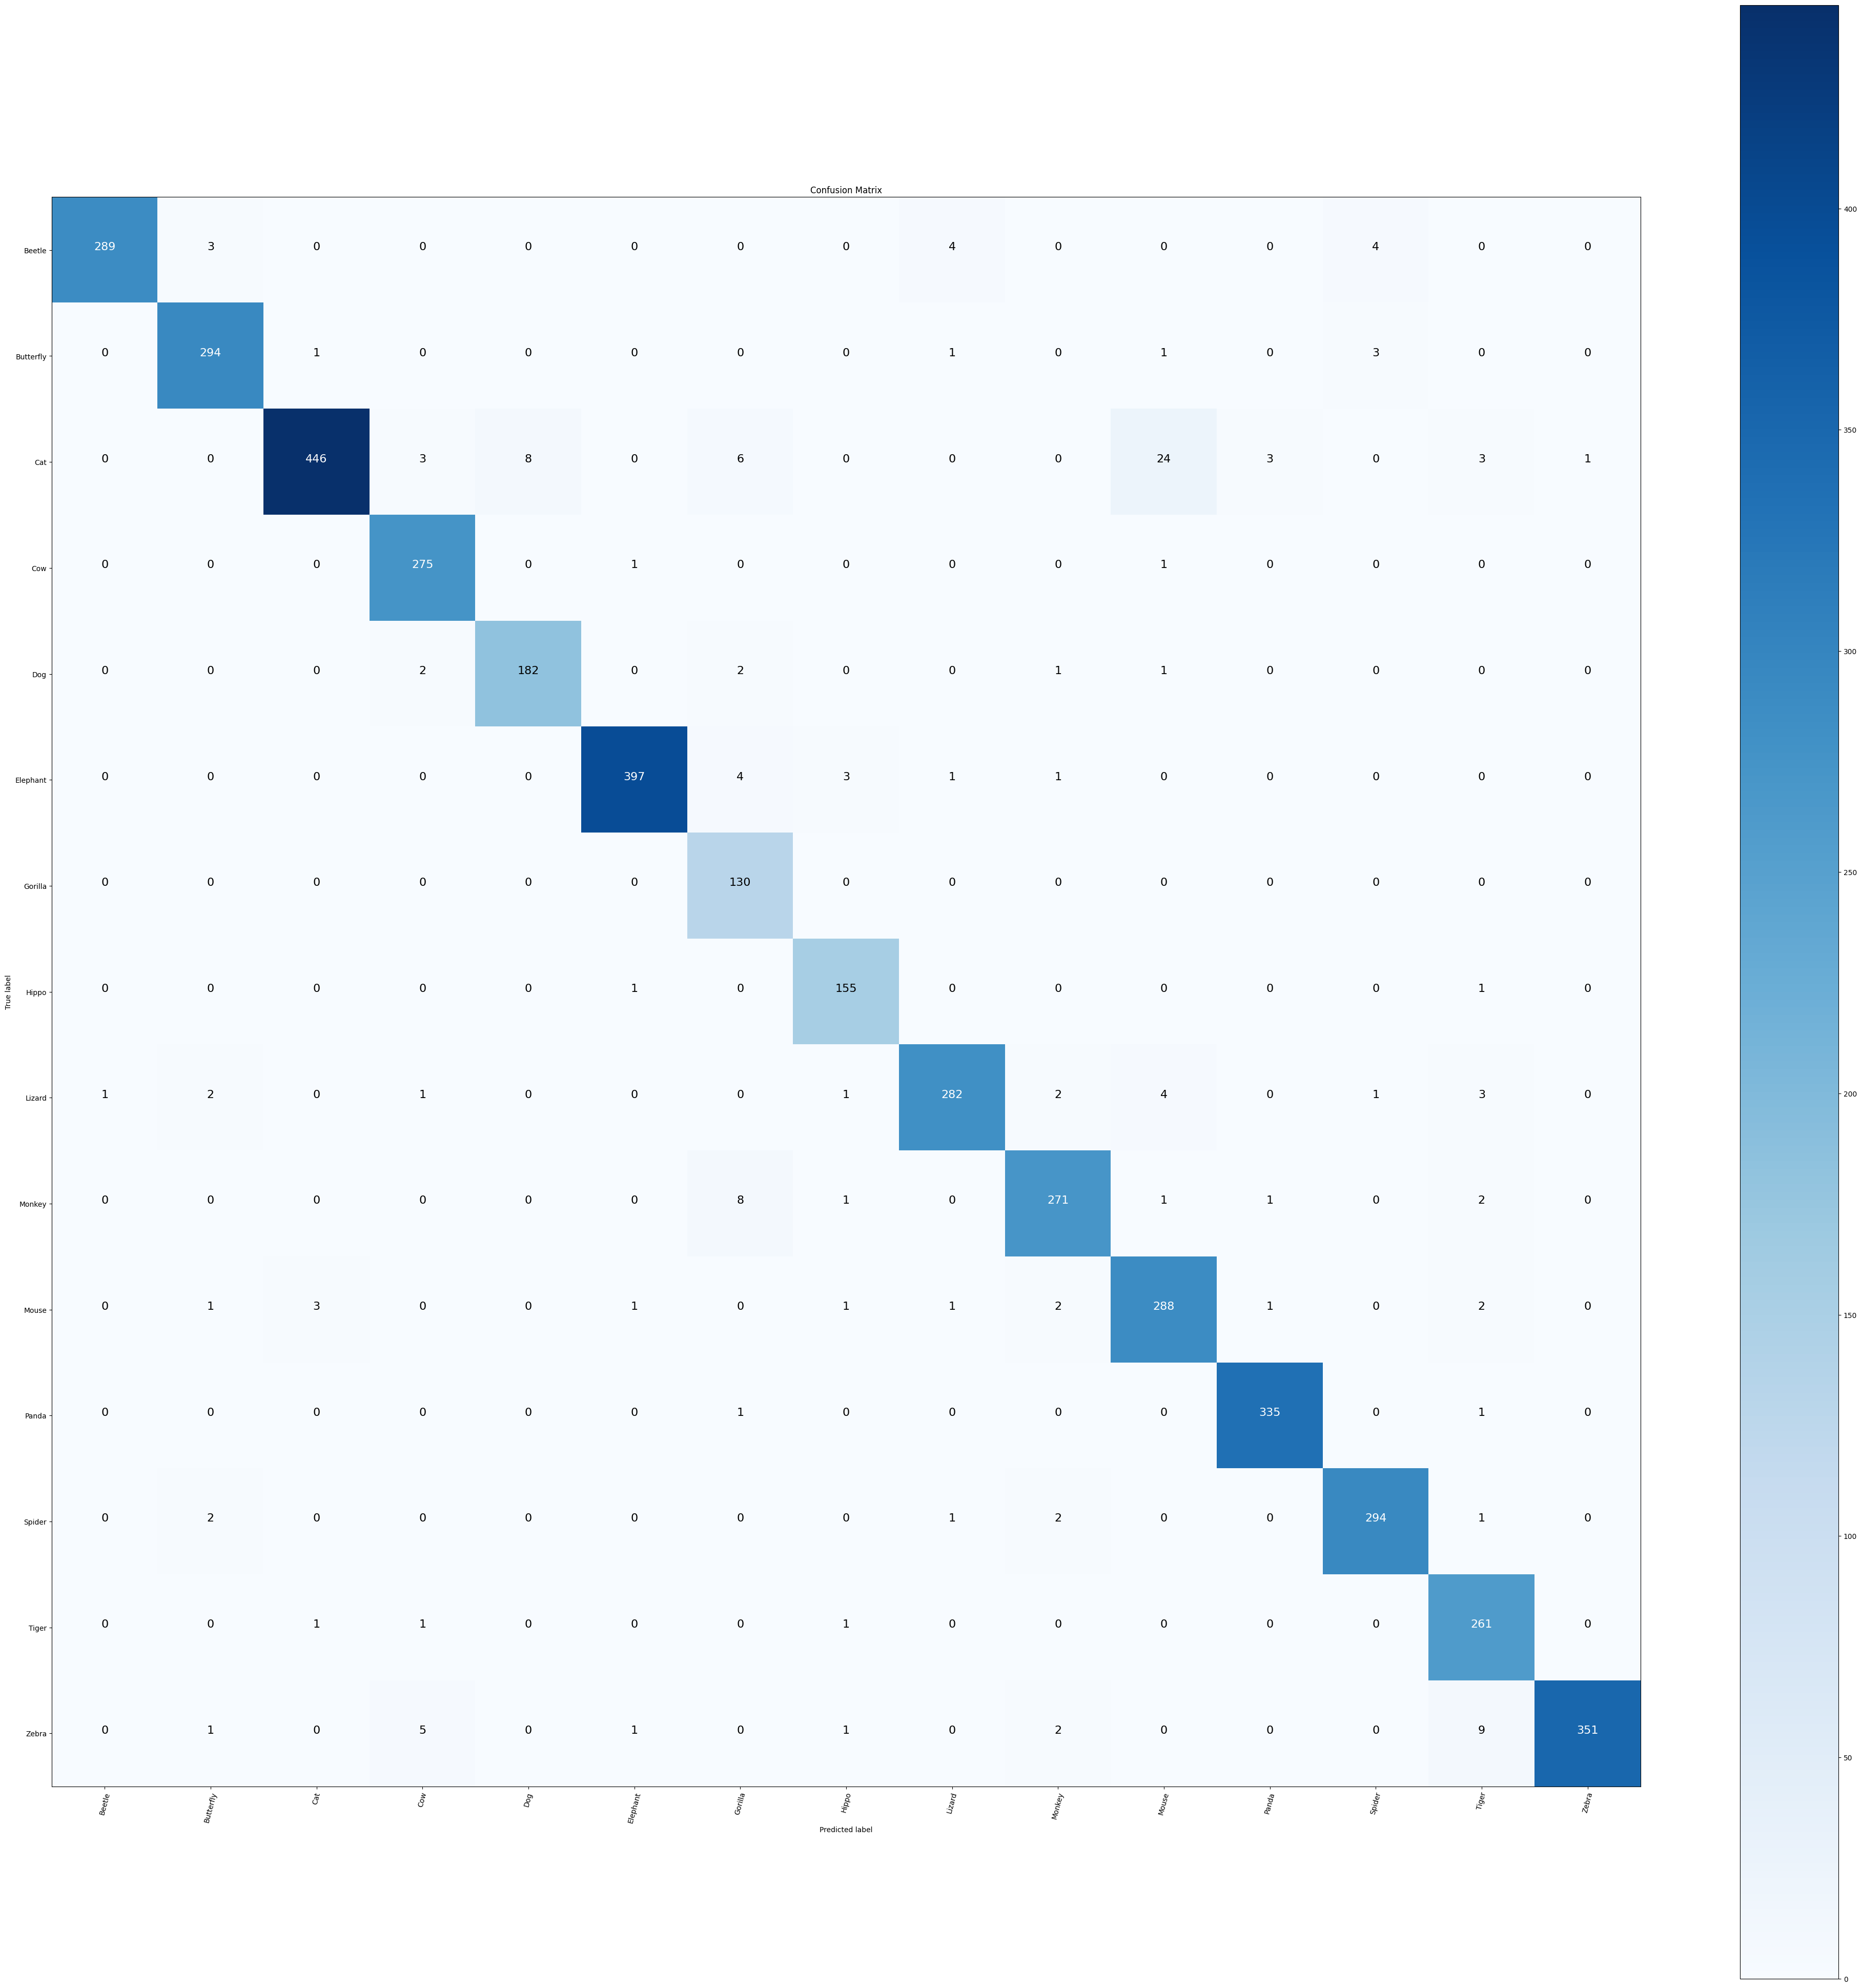

In [22]:
make_confusion_matrix(y_true = y_labels, y_pred =pred_index, classes = class_names, figsize =(50,50))